In [168]:
import torch 
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import math, itertools
import numpy as np
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
import math
from pathlib import Path
from PIL import Image

* Train an MLP classifier
* Plot loss
* Calculate accuracy, F1, etc.
* Error analysis (plot misclassified images)
* Error analysis: plot embeddings and
* Load OOD data sets, visualize
* Predict classes, visualize in the embedding space



1.1. Load data

In [169]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=512, shuffle=True) # change to 128 to make loss smoother - 256 doesn't converge
test_loader = DataLoader(testset, batch_size=512, shuffle=True)

train size 60000, test size 10000


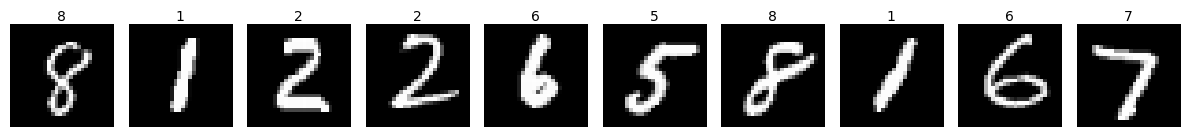

In [170]:
# understand data - visualise sample, understand the distribution of labels in train and test 
print(f"train size {len(trainset)}, test size {len(testset)}", )
# let's see what's in our dataset 
fig, axes = plt.subplots(1, 10, figsize = (12,2))
x, y = next(iter(train_loader))
for i, ax in enumerate(axes):
     ax.imshow(x[i,0,:,:], cmap = 'gray')
     ax.set_title(f"{int(y[i])}", fontsize=10, pad=2) 
     ax.axis('off')
plt.tight_layout()
plt.show()

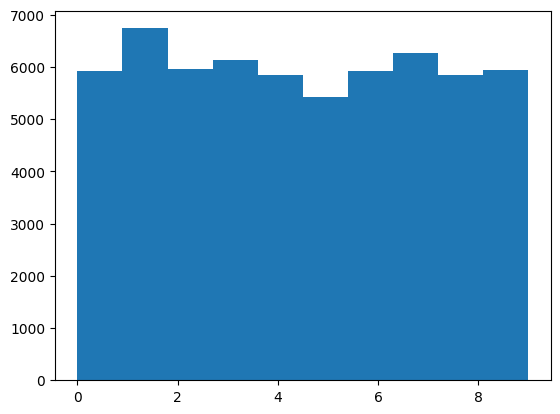

In [171]:
plt.hist(trainset.targets, bins=10);

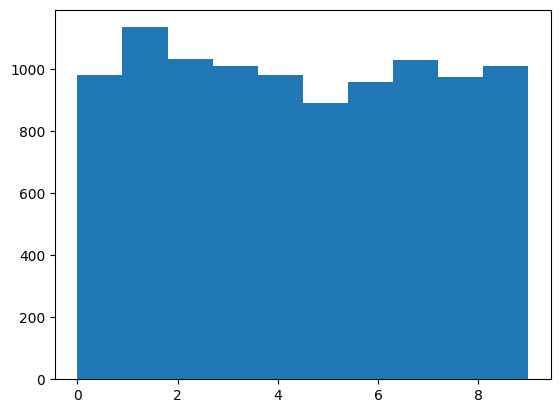

In [10]:
plt.hist(testset.targets, bins=10);

# MLP class
# make sure forward returns both logits and loss 


In [172]:
class MLP(nn.Module):
    def __init__(self, n_hidden=128, n_labels=10, width=28, length=28, dropout=0.2):
        super().__init__()
        self.n_hidden = n_hidden
        self.width = width
        self.length = length
        self.fc1 = nn.Linear(width*length, n_hidden)
        self.relu = nn.ReLU()
        # wanna avoid exploding gradients and will use batch norm = but let's see if we need it
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_labels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, imgs, labels=None):
        x = imgs.view(-1, self.width * self.length)
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        logits = self.fc3(out) # batch x labels
        if labels is None:
            return logits, None 
        loss = F.cross_entropy(logits, labels)
        return logits, loss
    
    def extract_embeddings(self, imgs):
        x = imgs.view(-1, self.width * self.length)
        out = self.fc1(x)
        out = self.dropout(self.relu(out))
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        return out
     

In [173]:
#basic checks 
#size of the model 
#expected train loss at the beginning
model = MLP()
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}\n")
print(f"expected initial train loss: {-math.log(1/10)}\n")

Total parameters: 118,282
Trainable parameters: 118,282

expected initial train loss: 2.3025850929940455



In [181]:
# train the model 
#initialise the model
model = MLP() 
optimizer = optim.AdamW(params = model.parameters(), lr=1e-3)
EPOCHS = 3
train_loss = []
test_loss = []

#metric = MulticlassF1Score(num_classes=10)

In [182]:
# trial run
# Cell 10
for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader):
        imgs, labels = data
        logits, loss = model(imgs, labels)
        optimizer.zero_grad()
        loss.backward()
        if i%100==0:
            print(f'step {i}, loss: {loss.item()}')
        optimizer.step()
        train_loss.append(loss.item())

    

step 0, loss: 2.3107991218566895
step 100, loss: 0.38902875781059265
step 0, loss: 0.2961820065975189
step 100, loss: 0.261222779750824
step 0, loss: 0.3054313063621521
step 100, loss: 0.25647982954978943


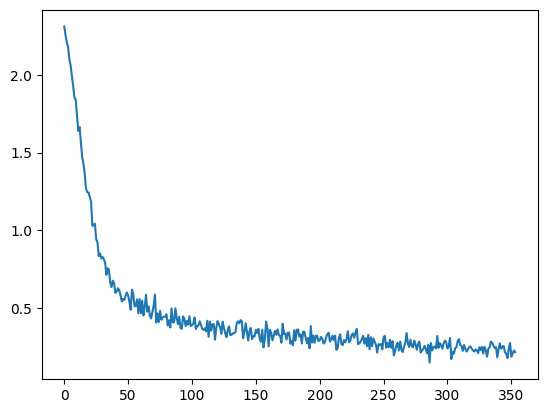

In [183]:
# plot all losses
plt.plot(train_loss)

In [184]:
# Cell 10
# include test loss
model = MLP()
optimizer = optim.AdamW(params = model.parameters(), lr=1e-3)
train_loss = []
test_loss = []
for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader):
        imgs, labels = data
        logits, loss = model(imgs, labels)
        optimizer.zero_grad()
        loss.backward()
        if i%100==0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        optimizer.step()
        train_loss.append(loss.item())

    model.eval()
    
    test_loss_i = 0
    for imgs, labels in test_loader:
        logits, loss = model(imgs, labels)
        test_loss_i += loss.item()
    test_loss.append(test_loss_i/len(test_loader))
    

epoch: 0, step: 0, loss: 2.3024816513061523
epoch: 0, step: 100, loss: 0.48004579544067383
epoch: 1, step: 0, loss: 0.3505822718143463
epoch: 1, step: 100, loss: 0.29599064588546753
epoch: 2, step: 0, loss: 0.28423622250556946
epoch: 2, step: 100, loss: 0.22722895443439484


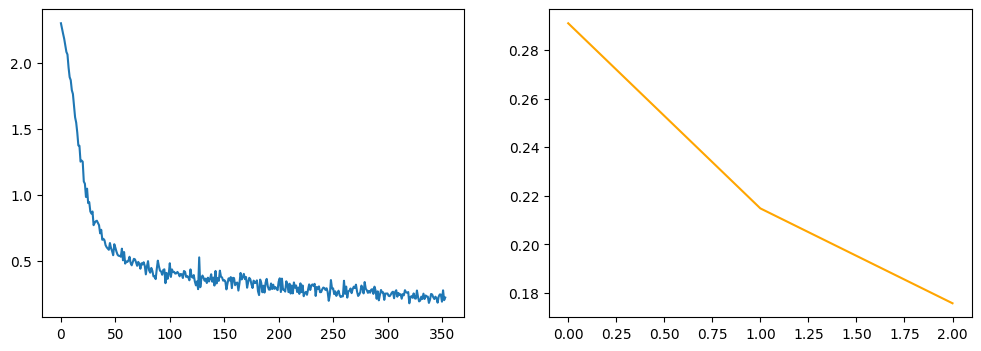

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_loss);
axes[1].plot(test_loss, color = 'orange');

In [186]:
train_loss[-1], test_loss[-1]

(0.2197461575269699, 0.17575872763991357)

In [ ]:
# Cell 10
# include other evals 
import importlib, utils
importlib.reload(utils)          # refresh the module from disk
from utils import evaluate 

train_metrics, test_metrics = [], []
model = MLP() 
optimizer = optim.AdamW(params = model.parameters(), lr=1e-3)
train_loss = []
test_loss = []

for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader):
        imgs, labels = data
        logits, loss = model(imgs, labels)
        optimizer.zero_grad()
        loss.backward()
        if i%100==0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        optimizer.step()
        train_loss.append(loss.item())

    model.eval()
    
    test_loss_i = 0
    for imgs, labels in test_loader:
        logits, loss = model(imgs, labels)
        test_loss_i += loss.item()
    test_loss.append(test_loss_i/len(test_loader))
    
    # Evaluate at the end of the epoch with evaluate
    tr = evaluate("train", model, train_loader, test_loader)
    te = evaluate("test",model, train_loader, test_loader)
    train_metrics.append(tr)
    test_metrics.append(te)
    


epoch: 0, step: 0, loss: 2.306999683380127
epoch: 0, step: 100, loss: 0.4854018986225128
epoch: 1, step: 0, loss: 0.42252397537231445
epoch: 1, step: 100, loss: 0.2977672517299652
epoch: 2, step: 0, loss: 0.23930872976779938
epoch: 2, step: 100, loss: 0.22654622793197632


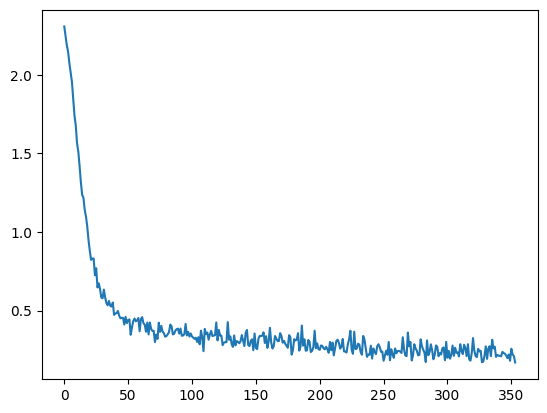

In [54]:
plt.plot(train_loss)

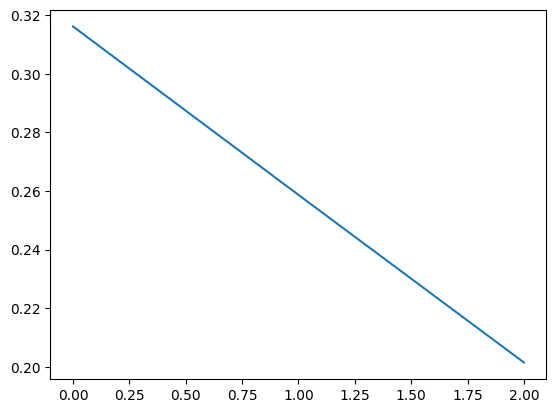

In [76]:
plt.plot(test_loss)

In [99]:
from utils import plot_training_curves

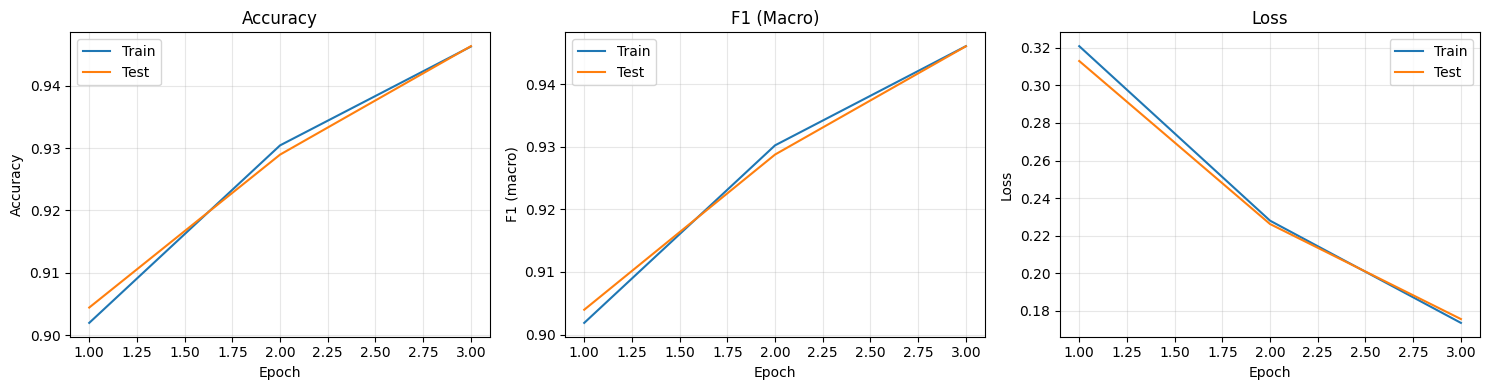

In [100]:
plot_training_curves(train_metrics, test_metrics)

In [ ]:
# train for 30 epochs
# include other evals 
# SKIP THIS CELL AND LOAD ALREADY TRAINED MODEL IN THE NEXT CELL
import importlib, utils
importlib.reload(utils)          # refresh the module from disk
from utils import evaluate 
train_metrics, test_metrics = [], []
model = MLP() 
optimizer = optim.AdamW(params = model.parameters(), lr=1e-3)
train_loss = []
test_loss = []
EPOCHS = 40

for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader):
        imgs, labels = data
        logits, loss = model(imgs, labels)
        optimizer.zero_grad()
        loss.backward()
        if i%100==0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        optimizer.step()
        train_loss.append(loss.item())

    model.eval()
    
    test_loss_i = 0
    for imgs, labels in test_loader:
        logits, loss = model(imgs, labels)
        test_loss_i += loss.item()
    test_loss.append(test_loss_i/len(test_loader))
    
    # Evaluate at the end of the epoch with evaluate
    tr = evaluate("train", model, train_loader, test_loader)
    te = evaluate("test",model, train_loader, test_loader)
    train_metrics.append(tr)
    test_metrics.append(te)
    


epoch: 0, step: 0, loss: 2.3180320262908936
epoch: 0, step: 100, loss: 0.3879205882549286
epoch: 1, step: 0, loss: 0.3986385464668274
epoch: 1, step: 100, loss: 0.2438908964395523
epoch: 2, step: 0, loss: 0.24050380289554596
epoch: 2, step: 100, loss: 0.2158859819173813
epoch: 3, step: 0, loss: 0.26107102632522583
epoch: 3, step: 100, loss: 0.16946008801460266
epoch: 4, step: 0, loss: 0.2083863914012909
epoch: 4, step: 100, loss: 0.24505086243152618
epoch: 5, step: 0, loss: 0.18679337203502655
epoch: 5, step: 100, loss: 0.1460796594619751
epoch: 6, step: 0, loss: 0.09803571552038193
epoch: 6, step: 100, loss: 0.13878494501113892
epoch: 7, step: 0, loss: 0.1825811266899109
epoch: 7, step: 100, loss: 0.13809436559677124
epoch: 8, step: 0, loss: 0.1133217141032219
epoch: 8, step: 100, loss: 0.10566398501396179
epoch: 9, step: 0, loss: 0.12598562240600586
epoch: 9, step: 100, loss: 0.1183784008026123
epoch: 10, step: 0, loss: 0.10886798799037933
epoch: 10, step: 100, loss: 0.11437452584505

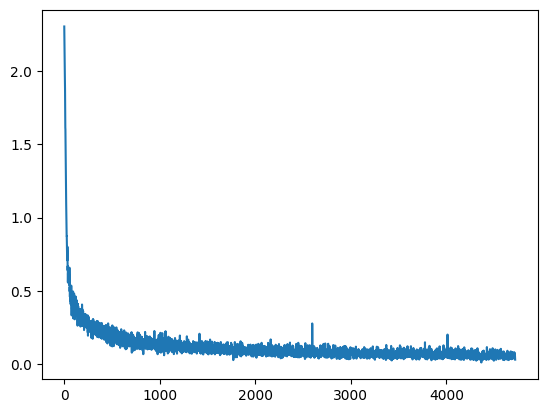

In [116]:
plt.plot(train_loss)

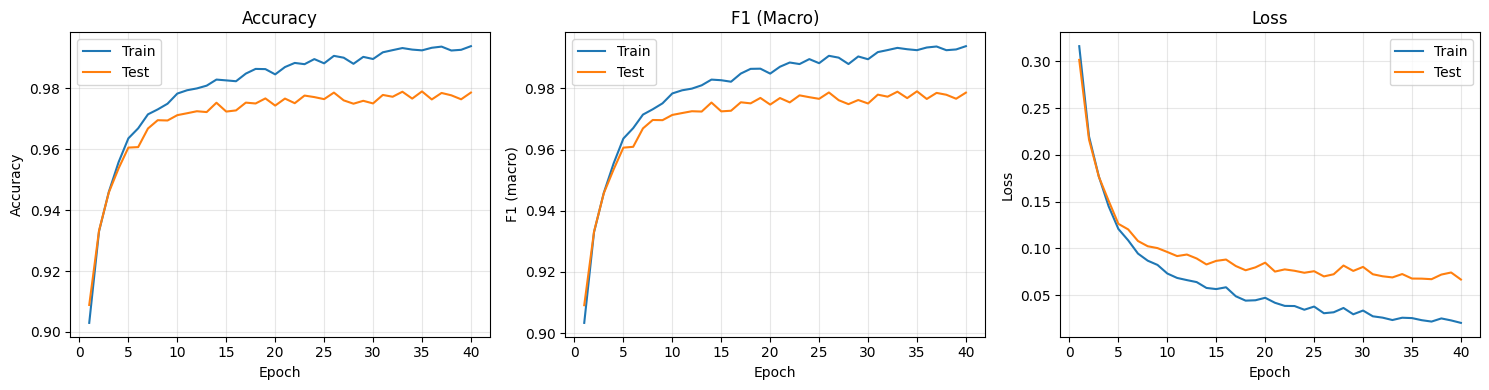

In [117]:
plot_training_curves(train_metrics, test_metrics)

In [118]:
# save model
# torch.save(model.state_dict(), "mlp_one_weights.pth")



In [189]:
model = MLP()                                # must match the MLP model's architecture
state = torch.load("mlp_one_weights.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()        

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [199]:
importlib.reload(utils) 
from utils import evaluate
evaluate('test', model, train_loader, test_loader, num_classes = 10)

{'accuracy': 0.9786434173583984,
 'f1_macro': 0.9786311984062195,
 'confusion_matrix': tensor([[ 970,    1,    2,    1,    1,    1,    0,    1,    2,    1],
         [   0, 1125,    2,    1,    0,    1,    2,    1,    3,    0],
         [   3,    3, 1015,    0,    2,    0,    1,    5,    3,    0],
         [   0,    0,    5,  978,    0,   11,    0,    9,    3,    4],
         [   0,    0,    3,    0,  962,    0,    5,    3,    2,    7],
         [   5,    0,    0,    4,    1,  872,    6,    1,    2,    1],
         [   4,    2,    1,    0,    4,    6,  938,    0,    3,    0],
         [   2,    5,   10,    1,    0,    0,    0, 1007,    2,    1],
         [   3,    0,    3,    2,    4,    4,    2,    3,  950,    3],
         [   3,    4,    0,    5,   11,    3,    1,    8,    3,  971]]),
 'loss': 0.06688824575394392}

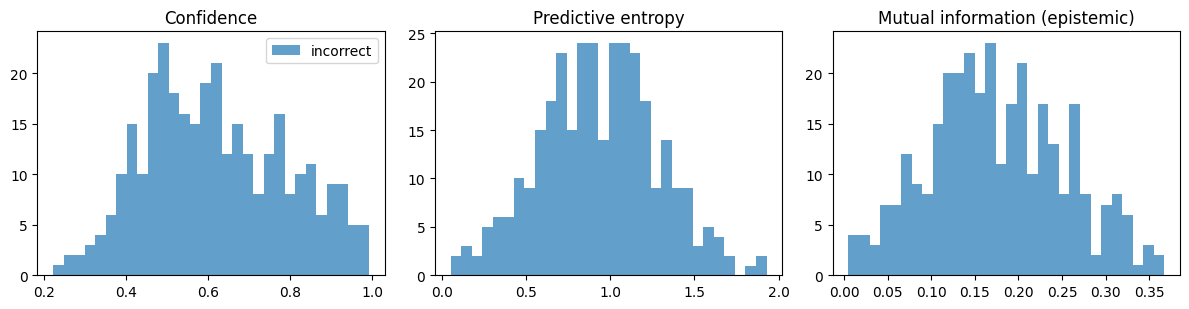

In [ ]:
# Cell 8: simple histograms to visualize uncertainty separation
import matplotlib.pyplot as plt

conf = out["confidence"].numpy()
H = out["H_pred"].numpy()
MI = out["MI"].numpy()
correct = (out["y_pred"] == out["y_true"]).numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 3.2))
#axes[0].hist(conf[correct], bins=30, alpha=0.7, label="correct")
axes[0].hist(conf[~correct], bins=30, alpha=0.7, label="incorrect")
axes[0].set_title("Confidence"); axes[0].legend()

#axes[1].hist(H[correct], bins=30, alpha=0.7, label="correct")
axes[1].hist(H[~correct], bins=30, alpha=0.7, label="incorrect")
axes[1].set_title("Predictive entropy")

#axes[2].hist(MI[correct], bins=30, alpha=0.7, label="correct")
axes[2].hist(MI[~correct], bins=30, alpha=0.7, label="incorrect")
axes[2].set_title("Mutual information (epistemic)")
plt.tight_layout(); plt.show()


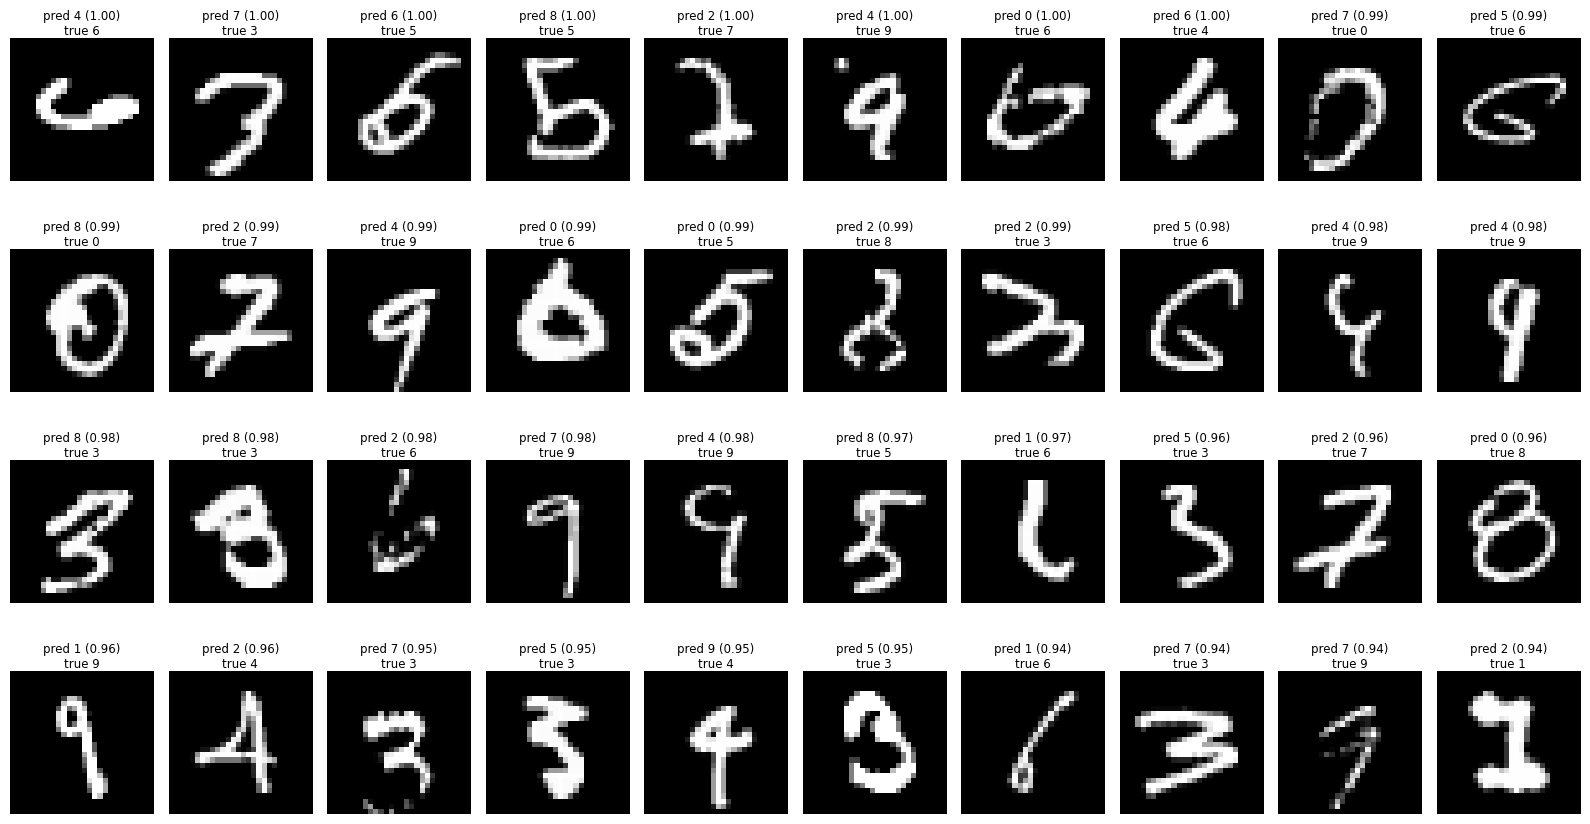

In [200]:
from utils import collect_misclassified, show_misclassified
records = collect_misclassified(model, test_loader)
show_misclassified(records,n=40)

In [192]:
# QUESTION - how best to show what is in there
type(records) 

list

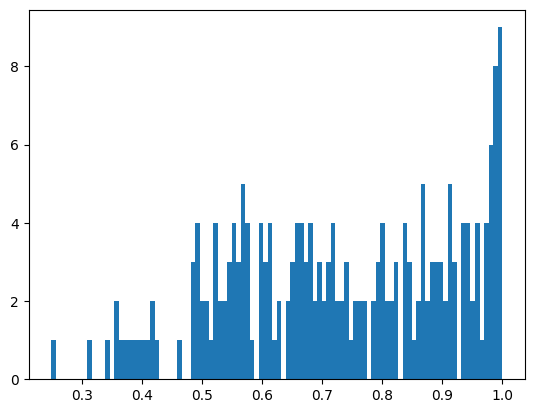

In [193]:
# plot confidences 
plt.hist([records[i]['conf'] for i in range(len(records))], bins=100);

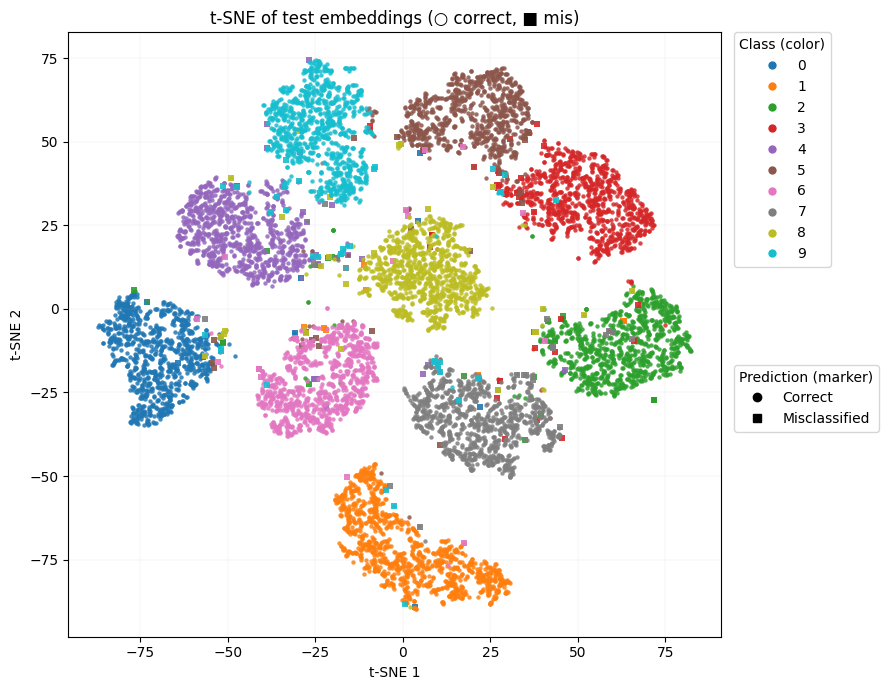

In [194]:
# what would you want here - perhaps 0.2 max confidence, not close to 1

#let's further examine where/how things got wrong 
importlib.reload(utils) 
from utils import tsne_plot_test_embeddings
# One call does everything and also gives you Z, y_true, y_pred back if you want them.
Z, y_true, y_pred = tsne_plot_test_embeddings(model, test_loader)



OOD 

In [195]:
# --- Load saved OOD datasets and create DataLoaders ---

importlib.reload(utils) 
from utils import OODDataset



# Your transform (same style as MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# --- Choose what you want to load ---
root = Path("./data/ood")

# 1) Separate datasets + loaders
ds_gauss   = OODDataset(root / "ood_gaussian.pt",          transform=transform)
ds_lines   = OODDataset(root / "ood_horizontal_lines.pt",  transform=transform)
ds_spiral  = OODDataset(root / "ood_spiral.pt",            transform=transform)
ds_checker = OODDataset(root / "ood_checkerboard.pt",      transform=transform)

loader_gauss   = DataLoader(ds_gauss,   batch_size=64, shuffle=False)
loader_lines   = DataLoader(ds_lines,   batch_size=64, shuffle=False)
loader_spiral  = DataLoader(ds_spiral,  batch_size=64, shuffle=False)
loader_checker = DataLoader(ds_checker, batch_size=64, shuffle=False)


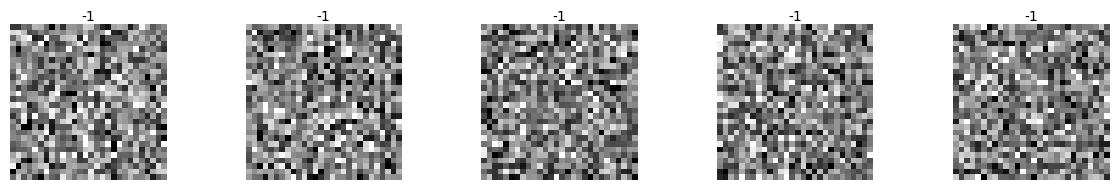

In [ ]:
# let's see images - replace loader_gauss with other loaders as specified above if you want to visualise the data:
fig, axes = plt.subplots(1, 5, figsize = (12,2))
x, y = next(iter(loader_gauss))
for i, ax in enumerate(axes):
     ax.imshow(x[i,0,:,:], cmap = 'gray')
     ax.set_title(f"{int(y[i])}", fontsize=10, pad=2) 
     ax.axis('off')
plt.tight_layout()
plt.show()

In [196]:
# plot confidences of predictions
all_confs = []
with torch.inference_mode():                
    for imgs, label in loader_lines:
        logits, _ = model(imgs)
        probs = torch.softmax(logits, dim=1)
        conf, pred = probs.max(dim=1) 
        all_conf = all_confs + conf.tolist()

    

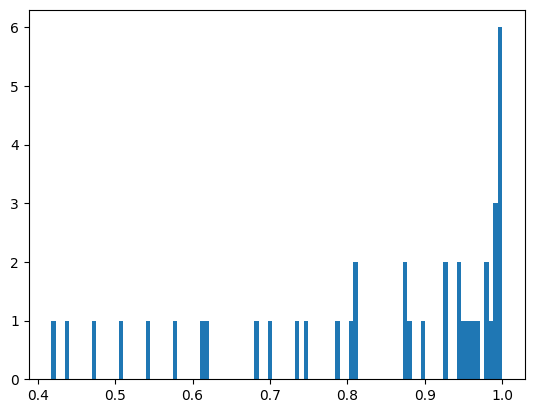

In [201]:
plt.hist(all_conf, bins=100);

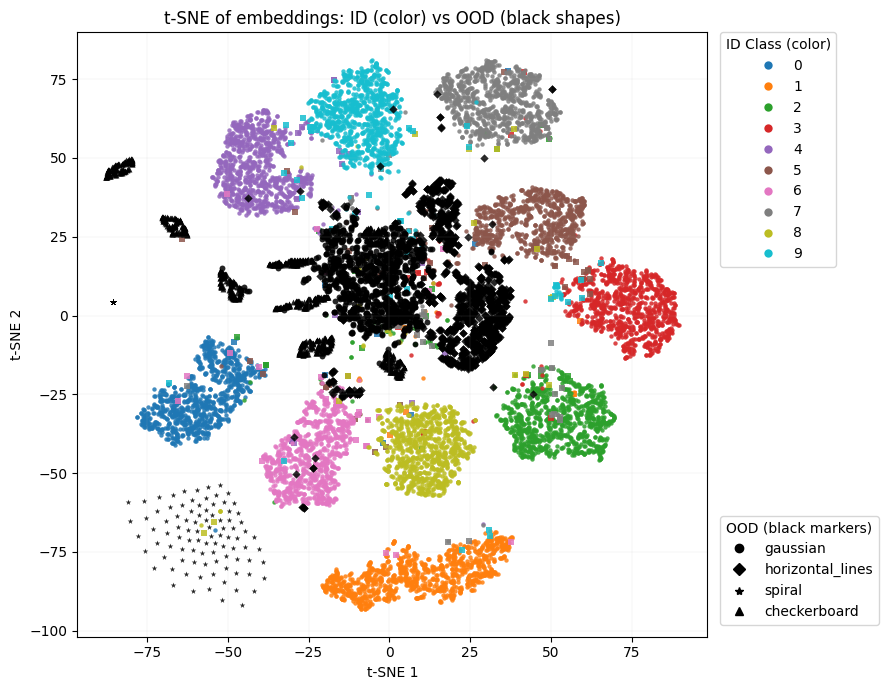

In [167]:
# note that the model is overconfident. 
# let's plot where all this is in the embedding space
importlib.reload(utils) 
from utils import tsne_plot_embeddings_with_ood

res = tsne_plot_embeddings_with_ood(
    model,
    id_loader=test_loader,                 # your in-distribution test loader
    ood_loaders={
        "gaussian": loader_gauss,
        "horizontal_lines": loader_lines,
        "spiral": loader_spiral,
        "checkerboard": loader_checker,
    },
    title="t-SNE of embeddings: ID (color) vs OOD (black shapes)",
    perplexity=30,
    n_iter=1000,
    random_state=0,
    learning_rate="auto",
)


In [206]:
importlib.reload(utils) 
from utils import plot_ood_total_entropy_MLP

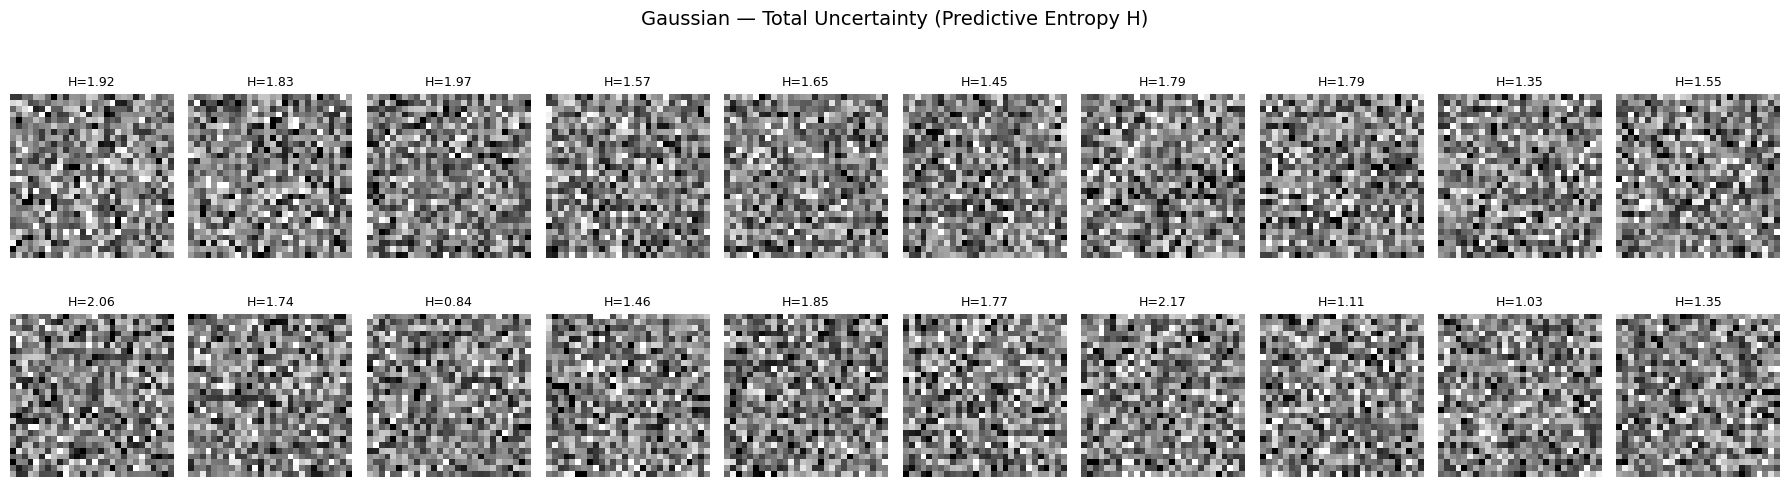

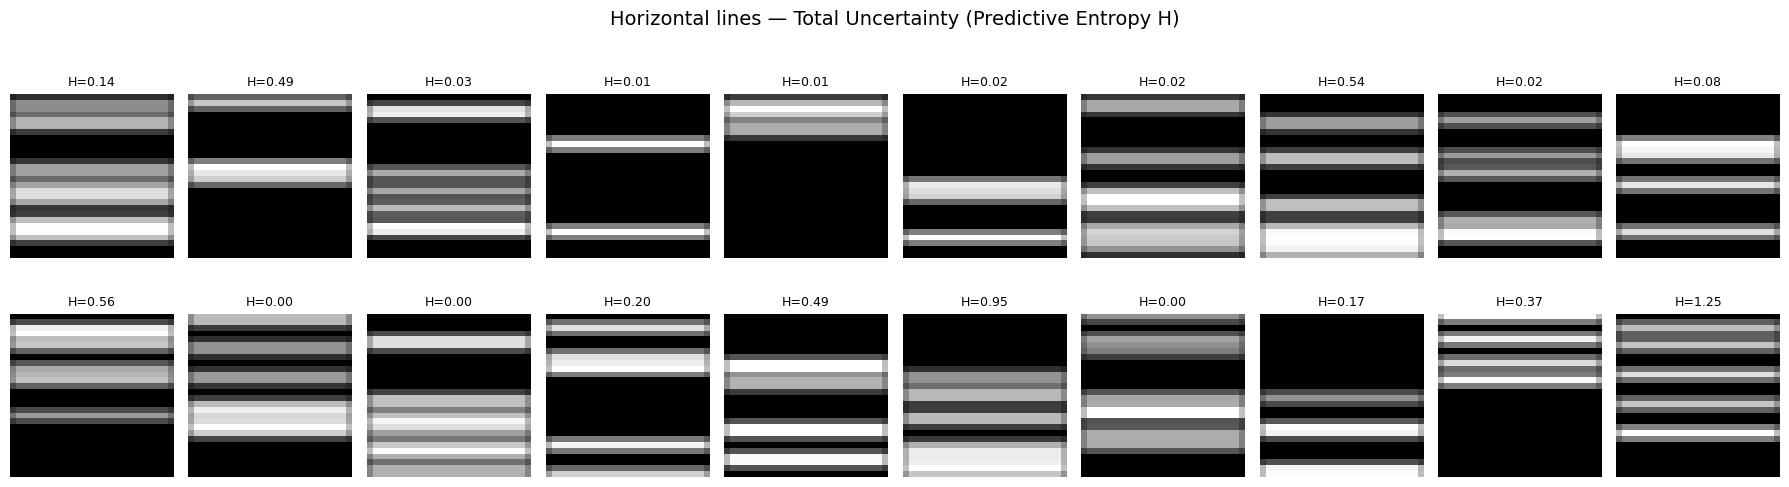

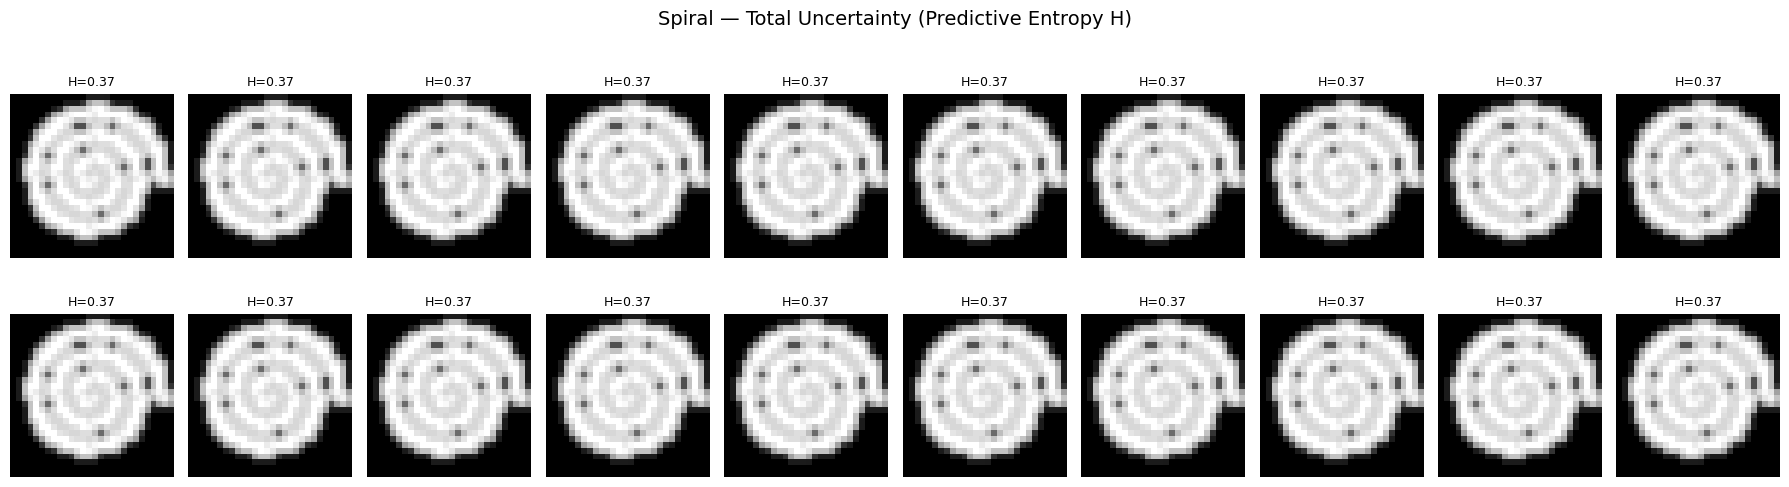

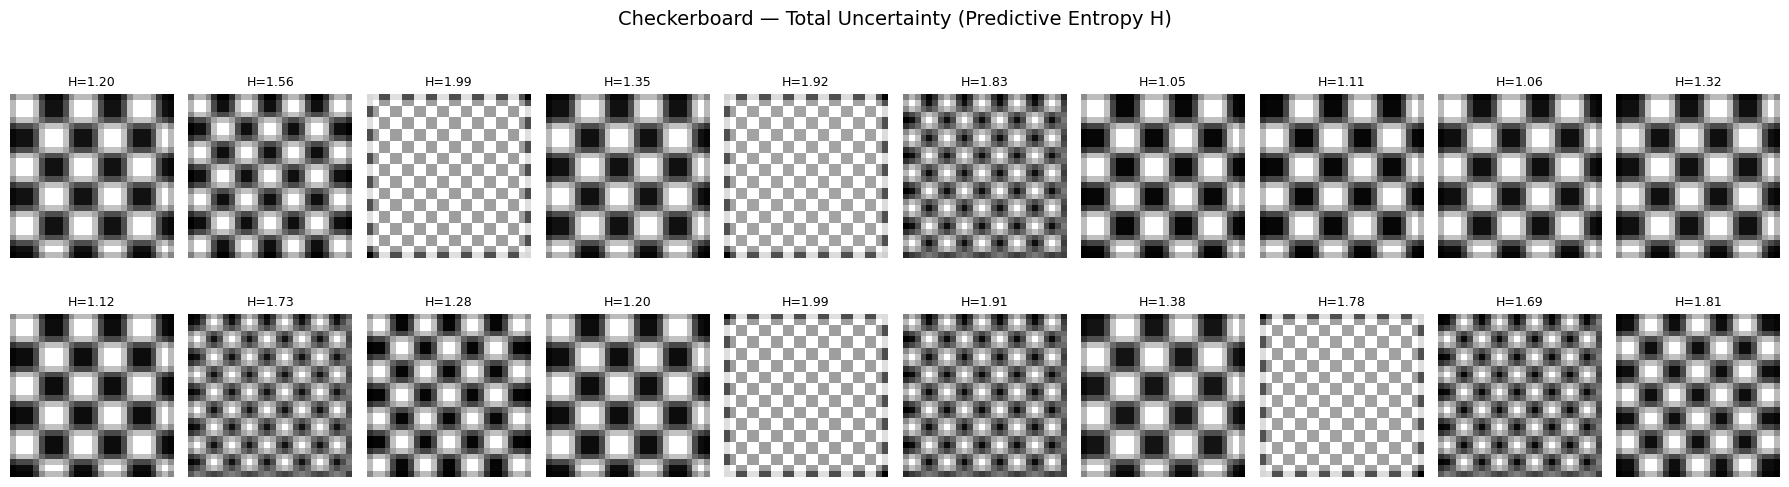

In [207]:
ood_loaders = [loader_gauss, loader_lines, loader_spiral, loader_checker]
names = ["Gaussian", "Horizontal lines", "Spiral", "Checkerboard"]

plot_ood_total_entropy_MLP(
    model=model,   # or any MLP() you trained/loaded
    ood_loaders=ood_loaders,
    names=names,
    n=20,
    cols=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
    denorm=True, mean=0.5, std=0.5,
    scaler=None  # or a calibrated TemperatureScaler
)
